In [1]:
%pip install tensorflow==2.10
%pip install scikit-learn
%pip install matplotlib
%matplotlib inline
%pip install keras_tuner

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.


### Import Libraries

In [11]:
import os
# import cv2
import glob
import pandas as pd

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import Dense
from keras.models import Sequential
from keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from keras.layers import Convolution2D,Dense,MaxPool2D,Activation,Dropout,Flatten
# added new import
from sklearn.metrics import confusion_matrix
import seaborn as sns
# from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D

# Python 3.9 Methods
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

ModuleNotFoundError: No module named 'seaborn'

### GPU Acceleration Check

In [3]:
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
physical_devices = tf.config.list_physical_devices()
print("Physical Devices:", physical_devices)

TensorFlow version: 2.10.0
Num GPUs Available:  1
Physical Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Load and Split Prepared Dara

In [4]:
# Load the data
x_input = np.load('prepared_data/x_input_combined.npy')
y_output = np.load('prepared_data/y_output_combined.npy')

# Ensure y is one-hot encoded
y_output = to_categorical(y_output, num_classes=4)

# Resizes images to 299 x 299 for optimal size for InceptionV3
x_input_resized = np.array([tf.image.resize(image, (299, 299)).numpy() for image in x_input])

Split dataset into training and testing with a 80/20 ratio

In [5]:
# Split the data into training and testing sets
x_input_train, x_input_test, y_output_train, y_output_test = train_test_split(x_input_resized, y_output, test_size=0.2, random_state=42)

# Printing Dimensions of data
print(f'X Training Data\nNumber of Rows: {x_input_train.shape[0]}\nPixel Dimensions: {x_input_train.shape[1]}x{x_input_train.shape[2]}x{x_input_train.shape[3]}\n')
print(f'Y Training Data\nNumber of Rows: {y_output_train.shape[0]}\nNumber of Classes: {y_output_train.shape[1]}\n')
print(f'X Testing Data\nNumber of Rows: {x_input_test.shape[0]}\nPixel Dimensions: {x_input_test.shape[1]}x{x_input_test.shape[2]}x{x_input_test.shape[3]}\n')
print(f'Y Testing Data\nNumber of Rows: {y_output_test.shape[0]}\nNumber of Classes: {y_output_test.shape[1]}')

X Training Data
Number of Rows: 1536
Pixel Dimensions: 299x299x3

Y Training Data
Number of Rows: 1536
Number of Classes: 4

X Testing Data
Number of Rows: 384
Pixel Dimensions: 299x299x3

Y Testing Data
Number of Rows: 384
Number of Classes: 4


### Load InceptionV3 Model

In [6]:
IMAGE_SIZE = [299, 299]

# Load the InceptionV3 model with weights pre-trained on ImageNet
inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# Freeze the existing weights
for layer in inception.layers:
    layer.trainable = False

# Add your own classification head to the model
x = GlobalAveragePooling2D()(inception.output)
x = Dense(256, activation='relu')(x)
output = Dense(4, activation='softmax')(x)

# Create a new model with the InceptionV3 base and your classification head
model = Model(inputs=inception.input, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the summary of the model
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

### Train Model

In [7]:
history = model.fit(
    x_input_train, y_output_train,
    steps_per_epoch=None,
    epochs=30,
    validation_data=(x_input_test, y_output_test),
    validation_steps=None,
    verbose=1,
    callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=0.001)],
    use_multiprocessing=False,
    shuffle=True
)


Epoch 1/30
48/48 [==============================] - 6s 78ms/step - loss: 1.0403 - accuracy: 0.6029 - val_loss: 0.6822 - val_accuracy: 0.7214 - lr: 0.0010
Epoch 2/30
48/48 [==============================] - 3s 63ms/step - loss: 0.5451 - accuracy: 0.7904 - val_loss: 0.5237 - val_accuracy: 0.8151 - lr: 0.0010
Epoch 3/30
48/48 [==============================] - 3s 62ms/step - loss: 0.3955 - accuracy: 0.8613 - val_loss: 0.4392 - val_accuracy: 0.8411 - lr: 0.0010
Epoch 4/30
48/48 [==============================] - 3s 61ms/step - loss: 0.2952 - accuracy: 0.9030 - val_loss: 0.4498 - val_accuracy: 0.8411 - lr: 0.0010
Epoch 5/30
48/48 [==============================] - 3s 61ms/step - loss: 0.2489 - accuracy: 0.9251 - val_loss: 0.3692 - val_accuracy: 0.8568 - lr: 0.0010
Epoch 6/30
48/48 [==============================] - 3s 61ms/step - loss: 0.1968 - accuracy: 0.9368 - val_loss: 0.4061 - val_accuracy: 0.8411 - lr: 0.0010
Epoch 7/30
48/48 [==============================] - 3s 61ms/step - loss: 0.1

## Evaluate Model

In [8]:
# Evaluate the model on training data
result_train = model.evaluate(x_input_train, y_output_train)
print(dict(zip(model.metrics_names, result_train)))

# Evaluate the model on testing data
result_test = model.evaluate(x_input_test, y_output_test)
print(dict(zip(model.metrics_names, result_test)))


48/48 [==============================] - 2s 49ms/step - loss: 0.0054 - accuracy: 1.0000
{'loss': 0.005412050988525152, 'accuracy': 1.0}
12/12 [==============================] - 1s 50ms/step - loss: 0.2084 - accuracy: 0.9271
{'loss': 0.20838534832000732, 'accuracy': 0.9270833134651184}


## Plot training and accuracy graphs

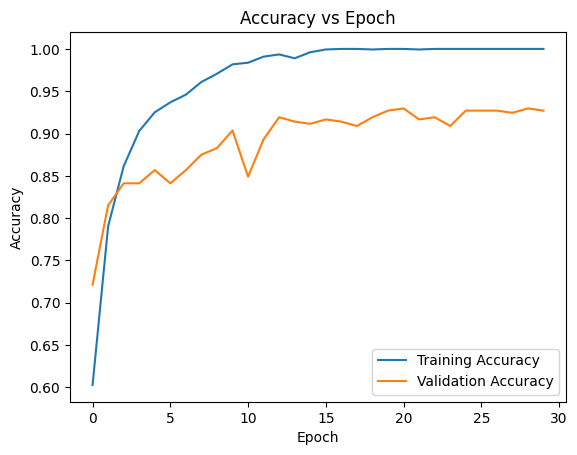

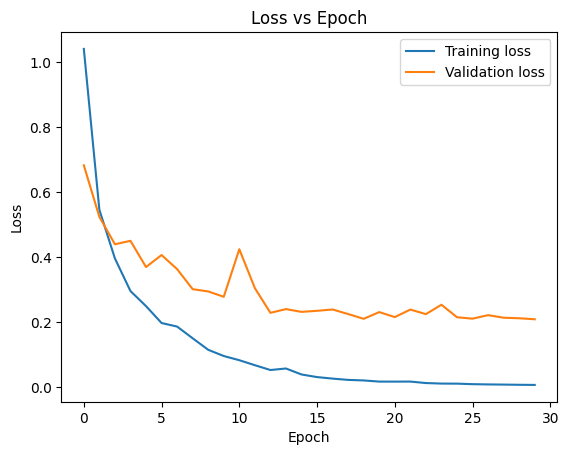

In [9]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Confusion Matrix

In [10]:
predictions = model.predict(x_input_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_output_test, axis=1)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


12/12 [==============================] - 1s 47ms/step


NameError: name 'sns' is not defined

<Figure size 800x600 with 0 Axes>

## Classification Report

In [ ]:
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print("Classification Report:")
print(report)
